In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

### Notes

What is important here is how to build a simple neural network in `torch`

- focus on the linear algerbra here and how that translates into simple code
- focus on tricks to get dimensionality correct


In [3]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [9]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [23]:
length = 0
for w in words:
    length += len(w)
print(length)

96099


In [27]:
# build the dataset

block_size = (
    3  # context length: how many characters do we take to predict the next one?
)
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size  # "padded context of zero tokens"
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)  # current running context
        Y.append(ix)  # target next character
        # print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]  # crop and append; "rolling context"

X = torch.tensor(X)
Y = torch.tensor(Y)

In [28]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [31]:
C = torch.randn((27, 2))  # 27 characters, 2 dimensional embedding
# we are embedding characters into 2 dimensions
C[5]

tensor([-0.7078,  0.3681])

In [34]:
F.one_hot(
    torch.tensor(5), num_classes=27
).float() @ C  # same as C[5]; one-hot encoding masks irrelevant dimensions

tensor([-0.7078,  0.3681])

In [39]:
C.shape

torch.Size([27, 2])

In [38]:
emb = C[X]  # how we simulateously embedd all of X in C
emb.shape

torch.Size([228146, 3, 2])

In [40]:
W1 = torch.randn((6, 100))  # 3 from context, 2 from embedding
b1 = torch.randn((100,))

In [41]:
emb @ W1 + b

RuntimeError: mat1 and mat2 shapes cannot be multiplied (684438x2 and 6x100)

In order to get correct dimensions to `@` we use `.concat` to squash the dimenshions in a naive way

**Note: this will not generalise**


In [46]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape  # input must be list

torch.Size([228146, 6])

To generalise for any block size we rather use `torch.unbind()` to get the list above


In [57]:
for t in torch.unbind(emb, 1):
    print(t.shape)

torch.Size([228146, 2])
torch.Size([228146, 2])
torch.Size([228146, 2])


In [59]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228146, 6])

A more efficient way is to use `.view()` since this manipulates `.storage()`


In [61]:
emb.view(-1, 6).shape

torch.Size([228146, 6])

In [63]:
emb.view(-1, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        ...,
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [68]:
h = emb.view(-1, 6) @ W1 + b1

In [72]:
h.shape

torch.Size([228146, 100])

In [69]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27,))

In [70]:
logits = h @ W2 + b2

In [71]:
counts = logits.exp()
prob = counts / counts.sum(-1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [76]:
# Every row sums to 1 --> normalised
prob[22000].sum()

tensor(1.)

In [78]:
# prob correct value
prob[torch.arange(len(prob)), Y]

tensor([1.0000e+00, 1.4708e-28, 2.0247e-25,  ..., 1.1692e-11, 8.9818e-06,
        5.6368e-25])

In [80]:
loss = prob[torch.arange(len(prob)), Y].log().mean()
loss

tensor(-inf)

In [107]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])  # also known as validation set
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [108]:
C = torch.randn((27, 2))

In [109]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [110]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [111]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [112]:
h

tensor([[-0.9535,  0.4767, -0.8762,  ..., -0.4202,  0.2386, -0.8809],
        [-0.8940,  0.9242, -0.8776,  ..., -0.9059,  0.7485, -0.3036],
        [-0.9824,  0.9851, -0.5815,  ..., -0.9986, -0.2883,  0.7029],
        ...,
        [-0.3173, -0.9937, -0.1870,  ...,  0.2164,  0.1346, -0.9995],
        [ 0.9198, -0.9124, -0.4138,  ..., -0.3515,  0.7876, -0.8827],
        [ 0.9353, -0.7939,  0.0827,  ...,  0.8678,  0.9876, -0.9998]])

In [113]:
h.shape

torch.Size([228146, 100])

In [114]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [115]:
logits = h @ W2 + b2

In [116]:
logits.shape

torch.Size([228146, 27])

In [117]:
counts = logits.exp()

In [118]:
prob = counts / counts.sum(1, keepdims=True)

In [119]:
prob.shape

torch.Size([228146, 27])

In [120]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [ ]:
# ------------ now made respectable :) ---------------

In [121]:
Xtr.shape, Ytr.shape  # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [122]:
# following captured in F.cross_entropy function
offset = (
    100  # because of normalisation, can add any offset to logits and get same result
)
logits = torch.tensor([-100, -3, 0, 100]) - offset
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

### Training loop


In [123]:
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [
    C,
    W1,
    b1,
    W2,
    b2,
]  # params in single list --> easier to count & pass to optimiser

In [124]:
sum(p.nelement() for p in parameters)  # number of parameters in total

11897

In [125]:
# NB
for p in parameters:
    p.requires_grad = True

In [126]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [127]:
lri = []
lossi = []
stepi = []

Inefficient method here can be numerically unstable


In [128]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  # 32 random numbers between zero and 5

    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 10) # index into Xtr using ix minibatch subset
    # (we generally have more steps with minibatch)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 200)
    logits = h @ W2 + b2  # (32, 27)

    # following captured in F.cross_entropy (Just classfication ???) --> efficient!!!
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Ytr[ix]].log().mean()

    loss = F.cross_entropy(logits, Ytr[ix])
    if i % 1000 == 0:
        print(f"i: {i}; loss: {loss.item()}")

    # backward pass
    for p in parameters:
        p.grad = None  # NB must zero the gradients before backward pass (else they accumulate)
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01  # learning rate decay; lr is very important
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

i: 0; loss: 24.630281448364258
i: 1000; loss: 4.220407962799072
i: 2000; loss: 3.5602591037750244
i: 3000; loss: 2.991800308227539
i: 4000; loss: 2.398388385772705
i: 5000; loss: 2.659816265106201
i: 6000; loss: 2.5006415843963623
i: 7000; loss: 2.561244010925293
i: 8000; loss: 2.839475154876709
i: 9000; loss: 2.6340792179107666
i: 10000; loss: 2.752163887023926
i: 11000; loss: 2.169093132019043
i: 12000; loss: 2.1071629524230957
i: 13000; loss: 2.8300271034240723
i: 14000; loss: 2.4181294441223145
i: 15000; loss: 3.0429415702819824
i: 16000; loss: 2.767133951187134
i: 17000; loss: 2.6495776176452637
i: 18000; loss: 2.08382511138916
i: 19000; loss: 2.034485101699829
i: 20000; loss: 2.647167921066284
i: 21000; loss: 2.378915786743164
i: 22000; loss: 2.301481246948242
i: 23000; loss: 2.1520423889160156
i: 24000; loss: 2.603400468826294
i: 25000; loss: 2.459768295288086
i: 26000; loss: 2.230572462081909
i: 27000; loss: 2.4466640949249268
i: 28000; loss: 2.5000979900360107
i: 29000; loss: 

### Minibatches create noise


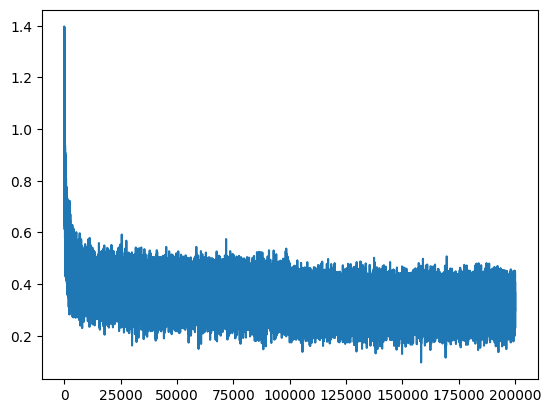

In [129]:
plt.plot(stepi, lossi)

In [797]:
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1260, grad_fn=<NllLossBackward0>)

In [130]:
emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)  # evaluating with Xdev, Ydev
loss  # if training loss and dev loss are similar, then we are not overfitting

tensor(2.1669, grad_fn=<NllLossBackward0>)

### Visualise Embeddings


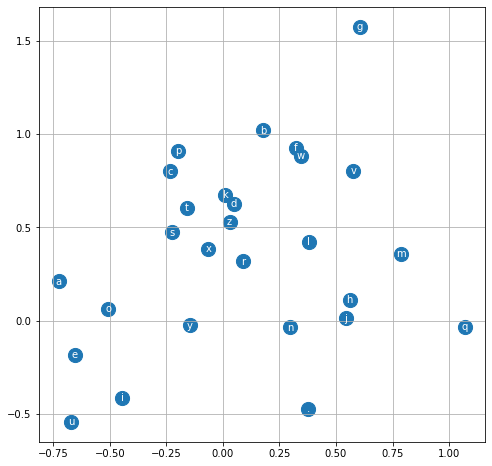

In [710]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(),
        C[i, 1].item(),
        i_to_s[i],
        ha="center",
        va="center",
        color="white",
    )
plt.grid("minor")

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [805]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

### Sample from model


In [131]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(i_to_s[i] for i in out))

carlah.
ambrilli.
kimri.
reh.
caspley.
kenrahnen.
delynn.
pareeigh.
kasia.
chaiivia.
leigh.
ham.
pori.
quintis.
lilea.
jadia.
wanthoniearixia.
kaeglifran.
edde.
iia.
